In [0]:
# http://pytorch.org/
from os import path
from wheel.pep425tags import get_abbr_impl, get_impl_ver, get_abi_tag
platform = '{}{}-{}'.format(get_abbr_impl(), get_impl_ver(), get_abi_tag())

accelerator = 'cu80' if path.exists('/opt/bin/nvidia-smi') else 'cpu'

!pip install -q http://download.pytorch.org/whl/{accelerator}/torch-0.3.0.post4-{platform}-linux_x86_64.whl torchvision
import torch

In [0]:
import torch
import torch.nn as nn
from torch.nn import init
from torch.autograd import Variable
import torch.optim as optim

import numpy as np

import matplotlib.pyplot as plt

### Data generator

In [0]:
class dataGenerator:
    def __init__(self):
        self.NUM_SAMPLES_train = 10e6
        self.NUM_SAMPLES_test = 10e4
        self.data_train = []
        self.data_test = []
        self.J = 3
        self.N = 50
        self.edge_density = 0.2
        self.random_noise = False
        self.noise = 0.03
        self.noise_model = 2
        
    def ErdosRenyi(self, p, N):
        W = np.zeros((N, N))
        for i in range(0, N - 1):
            for j in range(i + 1, N):
                add_edge = (np.random.uniform(0, 1) < p)
                if add_edge:
                    W[i, j] = 1
                W[j, i] = W[i, j]
        return W
        
    def compute_sample(self):
        sample = np.random.normal(self.mu_planted,self.sigma,self.d)
        sample = np.dot(self.planted_proj,sample)
        return sample
    
    def create_dataset(self):
        self.data_planted = []
        for _ in range(self.NUM_SAMPLES):
            sample = self.compute_sample_plantedData()
            self.data_planted.append(sample)
            
    def sample_batch(self, batch_size, cuda=True, volatile=False, planted=True):
        if planted:
            data = self.data_planted
        else:
            data = self.data_generated
        samples = torch.zeros(batch_size, self.d)
        for i in range(batch_size):
            ind = np.random.randint(0, self.NUM_SAMPLES-1)
            samples[i] = torch.from_numpy(data[ind])
        samples = Variable(samples, volatile=volatile)
        if cuda:
            return samples.cuda()
        else:
            return samples

In [0]:
def initialize_weights(m):
    if isinstance(m, nn.Linear) or isinstance(m, nn.ConvTranspose2d):
        init.xavier_uniform(m.weight.data)

In [0]:
dtype = torch.cuda.FloatTensor


### GNN Model

In [0]:
def gmul(input):
    W, x = input
    # x is a tensor of size (bs, N, num_features)
    # W is a tensor of size (bs, N, N, J)
    N = W.size()[-2]
    W = W.split(1, 3) # W is a list of J tensors of size (bs, N, N, 1)
    W = torch.cat(W, 1).squeeze(3) # W is now a tensor of size (bs, J*N, N)
    output = torch.bmm(W, x) # matrix multiplication (J*N,N) x (N,num_features): output has size (bs, J*N, num_features)
    output = output.split(N, 1) # output is a list of J tensors of size (bs, N, num_features)
    output = torch.cat(output, 2)
    # output has size (bs, N, J*num_features)
    return output

class Gconv(nn.Module):
    def __init__(self, feature_maps, J):
        super(Gconv, self).__init__()
        self.num_inputs = J*feature_maps[0] # size of the input
        self.num_outputs = feature_maps[1] # size of the output
        self.fc1 = nn.Linear(self.num_inputs, self.num_outputs // 2)
        self.fc2 = nn.Linear(self.num_inputs, self.num_outputs // 2)
        self.bn = nn.BatchNorm1d(self.num_outputs)

    def forward(self, input):
        W = input[0]
        x = gmul(input) # x has size (bs, N, num_inputs)
        x_size = x.size()
        x = x.contiguous() # makes sure that x is stored in a contiguous chunk of memory
        x = x.view(-1, self.num_inputs)
        x1 = F.relu(self.fc1(x)) # x_1 has size (bs*N, num_outputs // 2)
        x2 = self.fc2(x) # x_2 has size (bs*N, num_outputs // 2)
        x = torch.cat((x1, x2), 1) # x has size (bs*N, num_outputs)
        x = self.bn(x)
        x = x.view(*x_size[:-1], self.num_outputs) # x has size (bs, N, num_outputs)
        return W, x
      
class Gconv_last(nn.Module):
    def __init__(self, feature_maps, J):
        super(Gconv_last, self).__init__()
        self.num_inputs = J*feature_maps[0] # size of the input
        self.num_outputs = feature_maps[1] # size of the output
        self.fc = nn.Linear(self.num_inputs, self.num_outputs) # the only difference is that there is no activations layer

    def forward(self, input):
        W = input[0]
        x = gmul(input) # out has size (bs, N, num_inputs)
        x_size = x.size()
        x = x.contiguous()
        x = x.view(x_size[0]*x_size[1], -1) # x has size (bs*N, num_inputs)
        x = self.fc(x) # x has size (bs*N, num_outputs)
        x = x.view(*x_size[:-1], self.num_outputs) # x has size (bs, N, num_outputs)
        return W, x

class GNN(nn.Module):
    def __init__(self, num_features, num_layers, J):
        super(GNN, self).__init__()
        self.num_features = num_features
        self.num_layers = num_layers
        self.featuremap_first = [1, num_features]
        self.featuremap = [num_features, num_features]
        self.layer0 = Gconv(self.featuremap_first, J)
        for i in range(num_layers):
            module = Gconv(self.featuremap, J)
            self.add_module('layer{}'.format(i + 1), module)
        self.layerlast = Gconv_last(self.featuremap, J)

    def forward(self, input):
        cur = self.layer0(input)
        for i in range(self.num_layers):
            cur = self._modules['layer{}'.format(i+1)](cur)
        out = self.layerlast(cur)
        return out[1]

In [0]:
def bce_loss(input, target):
    neg_abs = - input.abs()
    loss = input.clamp(min=0) - input * target + (1 + neg_abs.exp()).log()
    return loss.mean()
  
def discriminator_loss(logits_real, logits_generated):
    N = logits_real.data.shape
    loss = bce_loss(logits_real, Variable(torch.ones(N)).type(dtype))
    loss += bce_loss(logits_generated, Variable(torch.zeros(N)).type(dtype))
    return loss

### Optimizer

In [0]:
def get_optimizer(model, weight_decay=0):
    optimizer = optim.Adam(model.type(dtype).parameters(), lr=1e-3, betas=(0.5, 0.999),weight_decay=weight_decay)
    return optimizer

### Discriminator trainer


In [0]:
def train_discriminator(generator, proj, D, optimizer, loss, show_every=100, batch_size=32, iterations=250):
    iter_count = 0
    generator.create_dataset_planted()
    generator.create_dataset_generated(proj)
    min_error = 1e6
    D.apply(initialize_weights)
    for iter_count in range(iterations):
            
        optimizer.zero_grad()
        real_data = generator.sample_batch(batch_size).type(dtype)
        generated_data = generator.sample_batch(batch_size, planted=False).type(dtype)
            
        logits_real = D(real_data).type(dtype)
        logits_generated = D(generated_data).type(dtype)
    
        error = loss(logits_real, logits_generated)
        error.backward()        
        optimizer.step()
            
        if (iter_count % show_every == 0):
            print('Iter: {}, Loss: {:.4}'.format(iter_count,error.data[0]))
            min_error = min(min_error,error.data[0])
            
def evaluate_discriminator(generator, proj, D, loss):
    batch_size = generator.NUM_SAMPLES
    generator.create_dataset_planted()
    generator.create_dataset_generated(proj)
    real_data = generator.sample_batch(batch_size).type(dtype)
    generated_data = generator.sample_batch(batch_size, planted=False).type(dtype)
    logits_real = D(real_data).type(dtype)
    logits_generated = D(generated_data).type(dtype)
    return loss(logits_real, logits_generated).data[0]

In [0]:
d = 10
D = discriminator(d).type(dtype)

### First test: 

Iter: 0, Loss: 1.495
Iter: 100, Loss: 0.1697
Iter: 200, Loss: 0.02567
0.05990394204854965
Iter: 0, Loss: 1.672
Iter: 100, Loss: 0.101
Iter: 200, Loss: 0.06532
0.05128973722457886
Iter: 0, Loss: 1.742
Iter: 100, Loss: 0.05991
Iter: 200, Loss: 0.05623
0.05239799991250038
Iter: 0, Loss: 1.337
Iter: 100, Loss: 0.1013
Iter: 200, Loss: 0.04829
0.05459965392947197
Iter: 0, Loss: 1.453
Iter: 100, Loss: 0.06462
Iter: 200, Loss: 0.07348
0.06269900500774384
Iter: 0, Loss: 1.619
Iter: 100, Loss: 0.05289
Iter: 200, Loss: 0.1299
0.06006249412894249
Iter: 0, Loss: 1.393
Iter: 100, Loss: 0.09084
Iter: 200, Loss: 0.08607
0.06041383743286133
Iter: 0, Loss: 1.71
Iter: 100, Loss: 0.1358
Iter: 200, Loss: 0.04714
0.06887094676494598
Iter: 0, Loss: 1.461
Iter: 100, Loss: 0.06273
Iter: 200, Loss: 0.07966
0.07956070452928543
Iter: 0, Loss: 1.389
Iter: 100, Loss: 1.359
Iter: 200, Loss: 1.401
1.3870524168014526


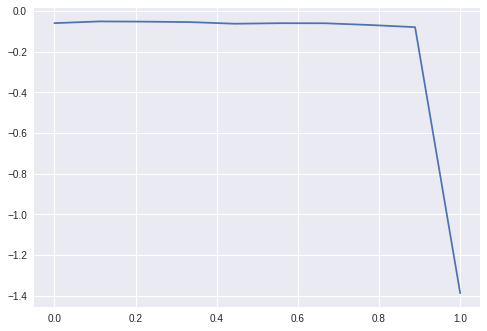

In [0]:
v_planted = np.zeros((d))
v_planted[0] = 1.
t_values = np.linspace(0.,1.,num=10)
errors = []
for t in t_values:
    v = (1-t) * np.ones((d)) + t * v_planted
    proj = np.dot(v.reshape(-1,1),v.reshape(1,-1)) / np.linalg.norm(v)**2
    train_discriminator(dataGenerator(d=d), proj, D, get_optimizer(D,weight_decay=1e-2), discriminator_loss)
    errors.append(evaluate_discriminator(dataGenerator(d=d), proj, D, discriminator_loss))
    print(errors[-1])

plt.plot(t_values,-np.array(errors))

### Second test

Iter: 0, Loss: 1.391
Iter: 100, Loss: 1.343
Iter: 200, Loss: 1.346
1.3974597454071045
Iter: 0, Loss: 1.405
Iter: 100, Loss: 0.3585
Iter: 200, Loss: 0.2643
0.2813757658004761
Iter: 0, Loss: 1.43
Iter: 100, Loss: 0.05661
Iter: 200, Loss: 0.008856
0.021946538239717484
Iter: 0, Loss: 0.9942
Iter: 100, Loss: 0.0126
Iter: 200, Loss: 0.005762
0.00806764792650938
Iter: 0, Loss: 1.351
Iter: 100, Loss: 0.008092
Iter: 200, Loss: 0.008765
0.007484745234251022
Iter: 0, Loss: 1.501
Iter: 100, Loss: 0.009862
Iter: 200, Loss: 0.007894
0.006526866927742958
Iter: 0, Loss: 1.97
Iter: 100, Loss: 0.01877
Iter: 200, Loss: 0.008266
0.007344206795096397
Iter: 0, Loss: 1.071
Iter: 100, Loss: 0.01175
Iter: 200, Loss: 0.007167
0.006544144824147224
Iter: 0, Loss: 0.8963
Iter: 100, Loss: 0.008785
Iter: 200, Loss: 0.006686
0.00681037362664938
Iter: 0, Loss: 0.9861
Iter: 100, Loss: 0.007767
Iter: 200, Loss: 0.007015
0.006226446945220232


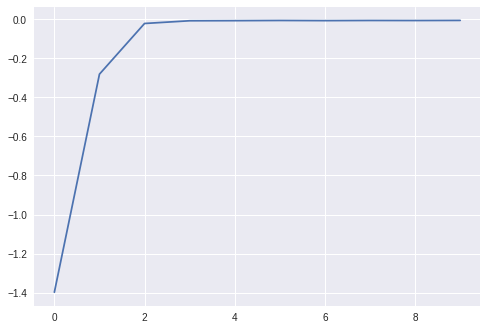

In [0]:
mu_values = np.arange(10, dtype=np.float)
errors = []
proj = np.eye(d)
for mu in mu_values:
    generator = dataGenerator(d=d, mu=mu, sigma=1.0)
    generator.planted_proj = proj
    train_discriminator(generator, proj, D, get_optimizer(D,weight_decay=1e-2), discriminator_loss)
    errors.append(evaluate_discriminator(generator, proj, D, discriminator_loss))
    print(errors[-1])

plt.plot(mu_values,-np.array(errors))